In [1]:
import Drone
from configurations import defaultConfig 
import numpy as np
from plottingFunctions import open_loop_plots, plot_rrt_lines_flipped
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from rrtplanner import RRTStar, plot_rrt_lines, plot_path, plot_og, plot_start_goal
import ConvexMotionPlanning
import copy
import inspect

## Testing occupency grid generation
Significantly increase the number of obstacles to check that they are being registered correctly

Text(0, 0.5, 'Vertical distance (m)')

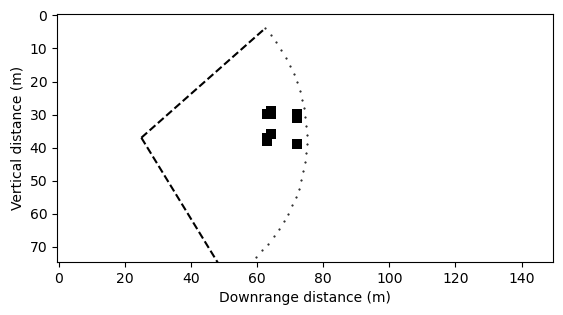

In [2]:
importlib.reload(Drone)

config = defaultConfig()
config.numObstacles = 25
drone = Drone.Drone(config, config)

thrustCommand = 4.4
fpaCommand = 0/180*np.pi
dynRef = drone.coherentCommand(thrustCommand,fpaCommand)
elivatorRef = drone.elevatorFromAlpha(dynRef[1]-dynRef[3])
stateRef = np.hstack(([0,50], dynRef))
action = (thrustCommand, elivatorRef, dynRef)
drone.reset(stateRef)

observation, grid, reward, terminated = drone.step(action)


# random data
fig, ax = plt.subplots()

# define the colors
cmap = mpl.colors.ListedColormap(['w', 'k'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot it
x = drone.ogOrigin[0]
z = drone.ogOrigin[1]
theta = drone.plant.state[3]
beam = drone.lidar_range
angle = drone.lidar_angle
res = drone.lidar_res
ax.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--')
ax.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--')
a = np.linspace(-angle/2,angle/2,int(res/3))
xs = x+beam*np.cos(theta+a)
zs = z+beam*np.sin(theta+a)
ax.plot(xs,zs,'k.',markersize=1)

ax.imshow(grid, interpolation='none', cmap=cmap, norm=norm)
ax.set_xlabel("Downrange distance (m)")
ax.set_ylabel("Vertical distance (m)")


# RRT Test

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Text(0, 0.5, 'Vertical distance in OG (m)')

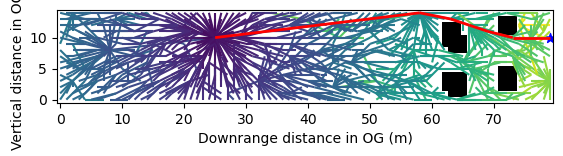

In [3]:
midpoint = drone.ogOrigin[1]
offset = 10
lookAhead = 54
orignX = drone.ogOrigin[0]
xstart = np.array([offset, orignX]) 
xgoal = np.array([offset, orignX+lookAhead])
n = 3000
r_rewire = 5
rrts = RRTStar(grid[midpoint-offset:midpoint+5, 0:80], n, r_rewire, pbar = False) 
T, gv = rrts.plan(xstart, xgoal)
path = rrts.route2gv(T, gv)
path_pts = rrts.vertices_as_ndarray(T, path)
tEnd = 450

fig = plt.figure()
ax = fig.add_subplot()

#these functions alter ax in-place.
plot_og(ax, grid[midpoint-offset:midpoint+5, 0:80].T)
plot_start_goal(ax, np.flip(xstart, 0), np.flip(xgoal, 0))
plot_rrt_lines_flipped(ax, T)
plot_path(ax, np.flip(path_pts,2))
Ttemp = copy.deepcopy(T)
ax.set_xlabel("Downrange distance in OG (m)")
ax.set_ylabel("Vertical distance in OG (m)")


## Trajectory Refignment

In [4]:
thrustCommandVal = 4.4
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))

iterations = 2000
iter = 0
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))

referencePoints, referenceVels = ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)
referencePointsDyn, referenceVelsDyn = ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)
for i in range(len(referencePointsDyn)):
    referencePointsDyn[i][0] = referencePointsDyn[i][0]-refStates[0]*np.sin(refStates[3])*i*drone.dt-offset
    referencePointsDyn[i][1] = referencePointsDyn[i][1]-refStates[0]*np.cos(refStates[3])*i*drone.dt-orignX
Acts, Bcts = drone.calculateCTSABMatrix(refStates, controlRef)
Aopt = np.eye(Acts.shape[0]+2)
#A = Aopt + env.calculateANumerical(stateRefFull, controlRef, env.rhoNom, step=10**-5)*env.dt
Aopt[0, 2] = drone.dt
Aopt[1, 5] = refStates[0]*drone.dt
Aopt[2:,2:] = Aopt[2:,2:]+Acts*drone.dt
Bopt = np.zeros([6,2])
Bopt[2:,0:1] = Bcts*drone.dt
alphaEst = refStates[1] - refStates[3]
Bopt[2, 1] = 1/drone.m*np.cos(alphaEst)*drone.dt
Bopt[5, 1] = 1/drone.m*np.sin(alphaEst)/refStates[0]*drone.dt
xstart = np.concatenate(([0.,0.], np.array(drone.stateEstimate) - np.array(refStates)))
xgoal = np.concatenate(([0.,50 - drone.stateEstimate[1]], [0.,0.,0.,0.]))
xsol, usol = ConvexMotionPlanning.localTrajOpt(Aopt, Bopt, tEnd, grid[midpoint-offset:, 0:80], referencePoints, referencePointsDyn, xstart, xgoal)
for i in range(np.min((tEnd, iterations-iter))):
    thrustCommand[iter+i] = usol[i][1] + thrustCommandVal 
    elivCommand[iter + i] = usol[i][0] + elivCommandRef
    xCommand[iter+i] = xsol[i][0]+refStates[0]*np.cos(0)*i*drone.dt+drone.plant.state[0]
    yCommand[iter+i] = xsol[i][1]+refStates[0]*np.sin(0)*i*drone.dt+drone.plant.state[1]
    refCommand[iter+i, :] = xsol[i][2:6].T + np.array(refStates)
open_loop_plots(0, tEnd,xCommand, yCommand,thrustCommand, elivCommand, drone)

(4059, 1)
(4059, 3606)
3608


IndexError: index 3607 is out of bounds for axis 1 with size 3606

In [9]:
referencePoints, referenceVels = ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)
print(midpoint)
print(referencePoints)


37
[array([10, 25]), array([10.        , 25.12288277]), array([10.        , 25.24576555]), array([10.        , 25.36864832]), array([10.        , 25.49153109]), array([10.        , 25.61441387]), array([10.        , 25.73729664]), array([10.        , 25.86017942]), array([10.        , 25.98306219]), array([10.        , 26.10594496]), array([10.        , 26.22882774]), array([10.        , 26.35171051]), array([10.        , 26.47459328]), array([10.        , 26.59747606]), array([10.        , 26.72035883]), array([10.       , 26.8432416]), array([10.        , 26.96612438]), array([10.        , 27.08900715]), array([10.        , 27.21188992]), array([10.       , 27.3347727]), array([10.        , 27.45765547]), array([10.        , 27.58053825]), array([10.        , 27.70342102]), array([10.        , 27.82630379]), array([10.        , 27.94918657]), array([10.        , 28.07206934]), array([10.        , 28.19495211]), array([10.        , 28.31783489]), array([10.        , 28.44071766]), arr

In [10]:
print(referencePoints)

[array([-7,  0]), array([14.97971174, 25.12172959]), array([14.95942347, 25.24345918]), array([14.93913521, 25.36518877]), array([14.91884694, 25.48691836]), array([14.89855868, 25.60864795]), array([14.87827041, 25.73037754]), array([14.85798215, 25.85210713]), array([14.83769388, 25.97383672]), array([14.81740562, 26.09556631]), array([14.79711735, 26.2172959 ]), array([14.77682909, 26.33902549]), array([14.75654082, 26.46075508]), array([14.73625256, 26.58248467]), array([14.71596429, 26.70421426]), array([14.69567603, 26.82594385]), array([14.67538776, 26.94767344]), array([14.6550995 , 27.06940303]), array([14.63481123, 27.19113262]), array([14.61452297, 27.31286221]), array([14.5942347, 27.4345918]), array([14.57394644, 27.55632139]), array([14.55365817, 27.67805098]), array([14.53336991, 27.79978057]), array([14.51308164, 27.92151016]), array([14.49279338, 28.04323975]), array([14.47250511, 28.16496934]), array([14.45221685, 28.28669893]), array([14.43192858, 28.40842852]), arra